# Siamese Model

## Upload the Data

### Import supporting libraries

In [1]:
import LoadData

2025-02-17 00:20:36.589587: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-02-17 00:20:36.610631: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1739751636.637926   34321 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1739751636.645595   34321 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-02-17 00:20:36.674875: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

### Loading Data in Batches

In [2]:
DBLoc = "./data/benchmark.db"

train_zero, val_zero, test_zero = LoadData.CreateEncodingDataset(DBLoc, 0)
train_one, val_one, test_one = LoadData.CreateEncodingDataset(DBLoc, 1)
train_non_zero, val_non_zero, test_non_zero = LoadData.CreateEncodingDataset(DBLoc, -1)

2025-02-17 00:20:41.294902: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: CUDA_ERROR_UNKNOWN: unknown error
2025-02-17 00:20:41.294949: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:137] retrieving CUDA diagnostic information for host: chuongg3-XPS-15-9520
2025-02-17 00:20:41.294961: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:144] hostname: chuongg3-XPS-15-9520
2025-02-17 00:20:41.295088: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:168] libcuda reported version is: 550.120.0
2025-02-17 00:20:41.295122: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:172] kernel reported version is: 550.120.0
2025-02-17 00:20:41.295130: I external/local_xla/xla/stream_executor/cuda/cuda_diagnostics.cc:259] kernel version seems to match DSO: 550.120.0


In [3]:
# train_set = train_zero.concatenate(train_one).concatenate(train_non_zero)
# val_set = val_zero.concatenate(val_one).concatenate(val_non_zero)
# test_set = test_zero.concatenate(test_one).concatenate(test_non_zero)

train_set = train_non_zero.concatenate(train_one).concatenate(train_zero)
val_set = val_non_zero.concatenate(val_one).concatenate(val_zero)
test_set = test_non_zero.concatenate(test_one).concatenate(test_zero)

## Siamese Model

### Tensorflow

In [4]:
import tensorflow as tf

In [5]:
# Check if tensorflow is using GPU
if tf.config.list_physical_devices('GPU'):
    print("TensorFlow is using GPU")
    print(f"GPU: {tf.config.list_physical_devices('GPU')}")
else:
    print("TensorFlow is not using GPU")

TensorFlow is not using GPU


#### Train Model

In [6]:
from tensorflow.keras.layers import Input, Dense, Lambda, Dropout
from tensorflow.keras.models import Model
import tensorflow.keras.backend as K

# Define the base network for feature extraction
def create_base_network(input_shape):
    inputs = Input(shape=input_shape)
    x = Dense(256, activation='relu')(inputs)
    x = Dense(128, activation='relu')(x)
    # outputs = Dense(64, activation='sigmoid')(x)  # Feature vector
    outputs = Dropout(0.25)(x)
    return Model(inputs, outputs)

In [7]:
# Define input shape
input_shape = (300,)

# Create the base network
base_network = create_base_network(input_shape)

# Siamese network inputs
input_a = Input(shape=input_shape)
input_b = Input(shape=input_shape)

# Generate embeddings
embedding_a = base_network(input_a)
embedding_b = base_network(input_b)

# Compute L1 distance
def l1_distance(vectors):
    x, y = vectors
    return K.abs(x - y)

distance = Lambda(l1_distance)([embedding_a, embedding_b])

# Output layer for similarity score (0 to 1 range)
output = Dense(1, activation='sigmoid')(distance)

# Define the Siamese model
siamese_model = Model(inputs=[input_a, input_b], outputs=output)

# Compile the model
siamese_model.compile(loss="mean_squared_error", optimizer="adam", metrics=["mse"])

# Model summary
siamese_model.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 300)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional          │ (None, 128)       │    109,952 │ input_layer_1[0]… │
│ (Functional)        │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 128)       │          0 │ functional[0][0], │
│                     │                   │            │ functional[1][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1)         │        129 │ lambda[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 110,081 (430.00 KB)

 Trainable params: 110,081 (430.00 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
history = siamese_model.fit(train_zero, epochs=10, validation_data=val_set)

Epoch 1/10
Start of dataset (Score: 0)
Dataset Index (Score: 0): 10000
    311/Unknown 19s 30ms/step - loss: 1.9223e-05 - mse: 0.0192Dataset Index (Score: 0): 20000
    623/Unknown 28s 30ms/step - loss: 1.1091e-05 - mse: 0.0111Dataset Index (Score: 0): 30000
    936/Unknown 38s 30ms/step - loss: 7.9697e-06 - mse: 0.0080Dataset Index (Score: 0): 40000
   1248/Unknown 47s 30ms/step - loss: 6.2893e-06 - mse: 0.0063Dataset Index (Score: 0): 50000
   1562/Unknown 57s 30ms/step - loss: 5.2198e-06 - mse: 0.0052Dataset Index (Score: 0): 60000
   1873/Unknown 64s 29ms/step - loss: 4.4847e-06 - mse: 0.0045Dataset Index (Score: 0): 70000
   2185/Unknown 66s 26ms/step - loss: 3.9404e-06 - mse: 0.0039Dataset Index (Score: 0): 80000
   2493/Unknown 68s 23ms/step - loss: 3.5257e-06 - mse: 0.0035Dataset Index (Score: 0): 90000
   2806/Unknown 70s 22ms/step - loss: 3.1899e-06 - mse: 0.0032Dataset Index (Score: 0): 100000
   3119/Unknown 73s 20ms/step - loss: 2.9161e-06 - mse: 0.0029Dataset Index (Score

2025-02-17 00:22:04.051966: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/home/chuongg3/.local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


Dataset Index (Score: -1): 10000
Size of dataset (Score: -1): 13924
Start of dataset (Score: 1)
Size of dataset (Score: 1): 331
Start of dataset (Score: 0)
Dataset Index (Score: 0): 10000
Dataset Index (Score: 0): 20000
Dataset Index (Score: 0): 30000
Dataset Index (Score: 0): 40000
Dataset Index (Score: 0): 50000
Dataset Index (Score: 0): 60000
Dataset Index (Score: 0): 70000
Dataset Index (Score: 0): 80000
Dataset Index (Score: 0): 90000
Dataset Index (Score: 0): 100000
Dataset Index (Score: 0): 110000
Dataset Index (Score: 0): 120000
Dataset Index (Score: 0): 130000
Dataset Index (Score: 0): 140000
Dataset Index (Score: 0): 150000
Dataset Index (Score: 0): 160000
Dataset Index (Score: 0): 170000
4459/4459 ━━━━━━━━━━━━━━━━━━━━ 113s 23ms/step - loss: 2.1488e-06 - mse: 0.0021 - val_loss: 0.0018 - val_mse: 0.0044
Epoch 2/10


2025-02-17 00:22:35.367296: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Start of dataset (Score: 0)
Dataset Index (Score: 0): 10000
 312/4459 ━━━━━━━━━━━━━━━━━━━━ 29s 7ms/step - loss: 5.0464e-09 - mse: 5.0464e-06Dataset Index (Score: 0): 20000
 623/4459 ━━━━━━━━━━━━━━━━━━━━ 27s 7ms/step - loss: 4.2011e-09 - mse: 4.2011e-06Dataset Index (Score: 0): 30000
 932/4459 ━━━━━━━━━━━━━━━━━━━━ 25s 7ms/step - loss: 3.5425e-09 - mse: 3.5425e-06Dataset Index (Score: 0): 40000
1242/4459 ━━━━━━━━━━━━━━━━━━━━ 23s 7ms/step - loss: 3.0803e-09 - mse: 3.0803e-06Dataset Index (Score: 0): 50000
1562/4459 ━━━━━━━━━━━━━━━━━━━━ 20s 7ms/step - loss: 2.7387e-09 - mse: 2.7387e-06Dataset Index (Score: 0): 60000
1873/4459 ━━━━━━━━━━━━━━━━━━━━ 18s 7ms/step - loss: 2.4963e-09 - mse: 2.4963e-06Dataset Index (Score: 0): 70000
2182/4459 ━━━━━━━━━━━━━━━━━━━━ 16s 7ms/step - loss: 2.3304e-09 - mse: 2.3304e-06Dataset Index (Score: 0): 80000
2498/4459 ━━━━━━━━━━━━━━━━━━━━ 14s 7ms/step - loss: 2.1863e-09 - mse: 2.1863e-06Dataset Index (Score: 0): 90000
2806/4459 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step 

2025-02-17 00:23:42.209893: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


Start of dataset (Score: 0)
Dataset Index (Score: 0): 10000
 309/4459 ━━━━━━━━━━━━━━━━━━━━ 32s 8ms/step - loss: 8.7386e-10 - mse: 8.7386e-07Dataset Index (Score: 0): 20000
 624/4459 ━━━━━━━━━━━━━━━━━━━━ 29s 8ms/step - loss: 9.4644e-10 - mse: 9.4644e-07Dataset Index (Score: 0): 30000
 933/4459 ━━━━━━━━━━━━━━━━━━━━ 27s 8ms/step - loss: 8.7584e-10 - mse: 8.7584e-07Dataset Index (Score: 0): 40000
1246/4459 ━━━━━━━━━━━━━━━━━━━━ 24s 8ms/step - loss: 7.9943e-10 - mse: 7.9943e-07Dataset Index (Score: 0): 50000
1556/4459 ━━━━━━━━━━━━━━━━━━━━ 22s 8ms/step - loss: 7.3691e-10 - mse: 7.3691e-07Dataset Index (Score: 0): 60000
1870/4459 ━━━━━━━━━━━━━━━━━━━━ 19s 8ms/step - loss: 6.9447e-10 - mse: 6.9447e-07Dataset Index (Score: 0): 70000
2183/4459 ━━━━━━━━━━━━━━━━━━━━ 17s 8ms/step - loss: 6.5937e-10 - mse: 6.5937e-07Dataset Index (Score: 0): 80000
2499/4459 ━━━━━━━━━━━━━━━━━━━━ 14s 8ms/step - loss: 6.2809e-10 - mse: 6.2809e-07Dataset Index (Score: 0): 90000
2812/4459 ━━━━━━━━━━━━━━━━━━━━ 12s 8ms/step 

KeyboardInterrupt: 

KeyError: 'val_loss'

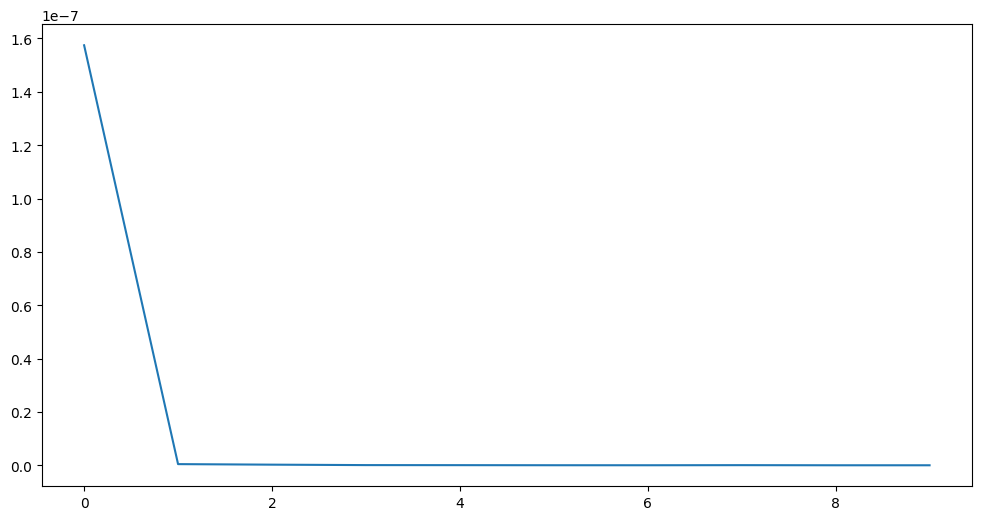

In [11]:
import matplotlib.pyplot as plt

# Plot training & validation loss values
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show()

# Plot training & validation MAE values
plt.figure(figsize=(12, 6))
plt.plot(history.history['mse'], label='Train MAE')
plt.plot(history.history['val_mse'], label='Validation MAE')
plt.title('Model Mean Squared Error')
plt.xlabel('Epoch')
plt.ylabel('MSE')
plt.legend(loc='upper right')
plt.show()
# history.history

In [ ]:
siamese_model.save("./data/siamese_model.keras")

#### Testing the difference

In [12]:
# import tensorflow as tf
# siamese_model = tf.keras.models.load_model("./data/siamese_model.keras")

# Make predictions on the testing set
predictions = siamese_model.predict(test_set)

# Print the predictions
print(predictions.shape)
# print(AlignmentScore_Test.shape)

1024/1024 ━━━━━━━━━━━━━━━━━━━━ 46s 8ms/step


/home/chuongg3/.local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


(32717, 1)


In [18]:
import numpy as np

y_true = []

for batch in test_set:
    (encoding1, encoding2), alignmentscore, weight = batch # Unpack features and labels
    # print(f"Alignment TYpe: {type(alignmentscore)}")
    # print(f"Alignment: {alignmentscore}")
    y_true.extend(alignmentscore.numpy())

AlignmentScore_Test = np.array(y_true)

In [20]:
print(AlignmentScore_Test.shape)
print(predictions.shape)

(32717,)
(32717, 1)


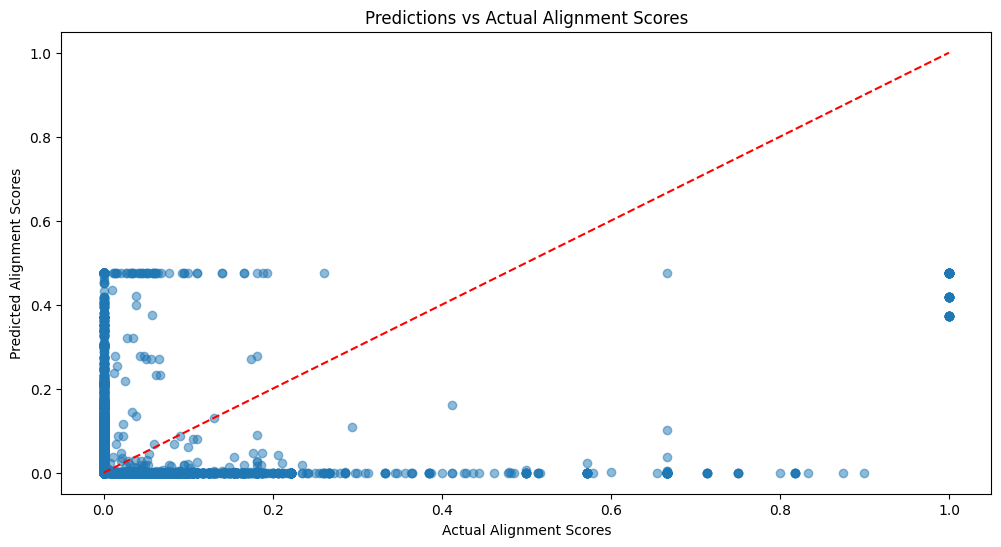

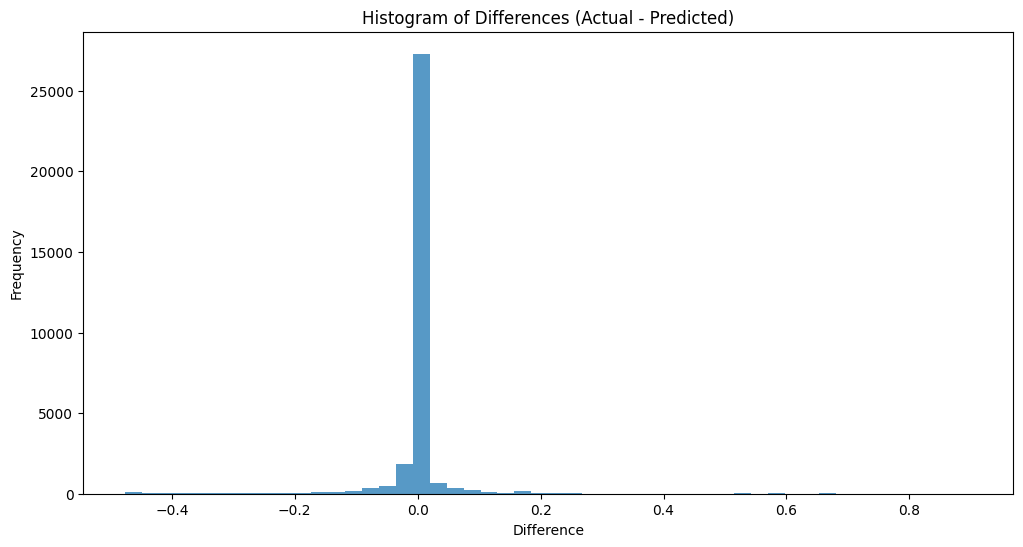

In [19]:
import matplotlib.pyplot as plt

# Scatter plot of predictions vs actual alignment scores
plt.figure(figsize=(12, 6))
plt.scatter(AlignmentScore_Test, predictions, alpha=0.5)
plt.plot([0, 1], [0, 1], 'r--')  # Line for reference
plt.title('Predictions vs Actual Alignment Scores')
plt.xlabel('Actual Alignment Scores')
plt.ylabel('Predicted Alignment Scores')
plt.show()

# Histogram of the differences
differences = AlignmentScore_Test - predictions.flatten()
plt.figure(figsize=(12, 6))
plt.hist(differences, bins=50, alpha=0.75)
plt.title('Histogram of Differences (Actual - Predicted)')
plt.xlabel('Difference')
plt.ylabel('Frequency')
plt.show()

#### Evaluate the Model using Tensorflow

In [22]:
# Evaluate the model on the testing set
evaluation = siamese_model.evaluate(test_non_zero.concatenate(test_one))

# Print the evaluation results
print(f"Test Loss: {evaluation[0]}")
print(f"Test MAE: {evaluation[1]}")

68/68 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0224 - mse: 0.0224
Test Loss: 0.03184065222740173
Test MAE: 0.031872525811195374


2025-02-15 19:53:10.098295: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 1147033478794680049
2025-02-15 19:53:10.098329: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 9677609121347557564
2025-02-15 19:53:10.098337: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 13176659246146110080
2025-02-15 19:53:10.098347: I tensorflow/core/framework/local_rendezvous.cc:424] Local rendezvous recv item cancelled. Key hash: 4030389488653788798
/home/chuongg3/.local/lib/python3.10/site-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


#### Custom Testing Function

In [ ]:
# Get the functions which has the highest alignment score
def GetBestMatchedFunction(df):
    pass

def EvaluateByClassification(df, predictions):
    # Find the function with the highest matc
    pass